# Imports

In [120]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Carregar dados de precificação e visualização inicial

In [121]:
train_df = pd.read_csv('teste_indicium_precificacao.csv')
train_df = train_df.set_index('id')
train_df.head()

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [122]:
train_df.shape

(48894, 15)

In [123]:
train_df.describe(exclude=np.number).T

,count,unique,top,freq
nome,48878,47904,Hillside Hotel,18
host_name,48873,11452,Michael,417
bairro_group,48894,5,Manhattan,21661
bairro,48894,221,Williamsburg,3920
room_type,48894,3,Entire home/apt,25409
ultima_review,38842,1764,2019-06-23,1413


In [124]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48894 entries, 2595 to 36487245
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome                           48878 non-null  object 
 1   host_id                        48894 non-null  int64  
 2   host_name                      48873 non-null  object 
 3   bairro_group                   48894 non-null  object 
 4   bairro                         48894 non-null  object 
 5   latitude                       48894 non-null  float64
 6   longitude                      48894 non-null  float64
 7   room_type                      48894 non-null  object 
 8   price                          48894 non-null  int64  
 9   minimo_noites                  48894 non-null  int64  
 10  numero_de_reviews              48894 non-null  int64  
 11  ultima_review                  38842 non-null  object 
 12  reviews_por_mes                38842 non-null

In [125]:
train_df.isnull().sum()

nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Valores nulos para as colunas ultima_review, reviews_por_mes, host_name e nome

Antes de lidar com esses valores nulos, devemos avaliar quais variáveis de entrada de interesse para o modelo de precificação. 

Na variável features, guardam-se as variáveis que são interessantes a priori para a especulação do preço da acomodação. Entre todas as variáveis, retiram-se as host_name, reviews_por_mes e ultima_review. 



In [126]:
michaels = len(train_df[train_df['host_name']== "Michael"]['host_id'].unique())
print('O número de identificadores de usuários relacionados ao nome "Michael" é dado por {}, revelando como os valores para host_names podem ser ambíguos!'.format(michaels))

O número de identificadores de usuários relacionados ao nome "Michael" é dado por 335, revelando como os valores para host_names podem ser ambíguos!


- O host_name, pois podem haver nomes iguais, como o caso acima para o nome Michael, que se repete 417 vezes para diferentes host_id. A variável mais relevante que o host_name seria o host_id, sendo esse último unívoco para cada usuário.

- As variáveis reviews_por_mes e ultima review são encaradas como irrelevantes, a princípio, para os valores  por noite de quartos, uma vez que os valores de reviews_por_mes não dizem respeito ao tipo de review tampouco sobre a data em que as reviews foram realizadas. Enquanto o valor de ultima_review não informa nada sobre as reviews anteriores. 

In [127]:
features = list(train_df.columns)
# features.remove('price')
# features.remove('id')
# features.remove('nome')
features.remove('ultima_review')
features.remove('reviews_por_mes')
# features.remove('host_id')
features.remove('host_name')
features

['nome',
 'host_id',
 'bairro_group',
 'bairro',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimo_noites',
 'numero_de_reviews',
 'calculado_host_listings_count',
 'disponibilidade_365']

In [128]:
len(train_df)

48894

Com relação à última variável com valores nulos, tem-se que a coluna nome é relevante para o problema de negócio. Assim, opta-se por simplesmente eliminar os valores nulos por serem apenas 16 de 48.894.

Seguem os passos abaixo

In [129]:
train_df_cleaned = train_df[features]
train_df_cleaned.dropna(inplace=True)
train_df_cleaned.head()

/tmp/ipykernel_4879/416896384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cleaned.dropna(inplace=True)


,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129


Figuras ilustrando o comportamento da variável preço. À esquerda, gráfico de dispersão, à direita, histograma. 


/tmp/ipykernel_4879/3257862820.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


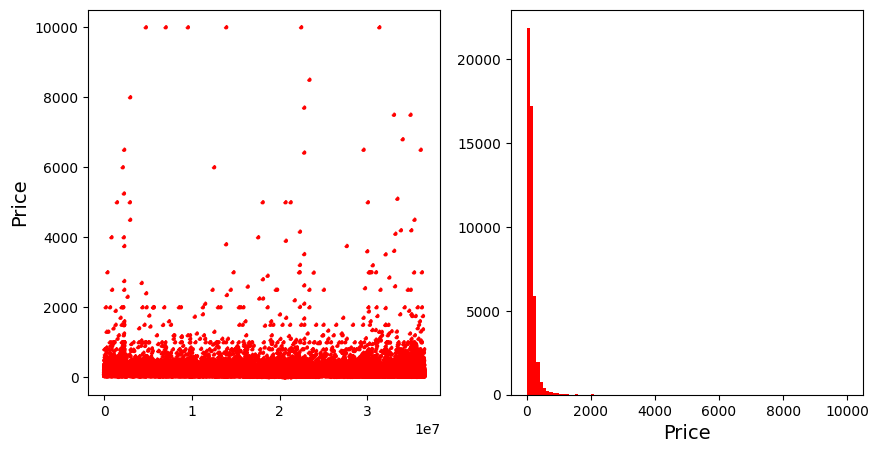

In [130]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(train_df_cleaned.index, train_df_cleaned['price'], color = 'red', linestyle = '--', s = 5)
ax[1].hist(train_df_cleaned['price'], color = 'red', rwidth = 1, bins = 100, )

ax[0].set_ylabel('Price', size = 14)

ax[1].set_xlabel('Price', size = 14)
# ax.set_ylim(0, 1000)
# ax.set_xlim(0, 100)
print("Figuras ilustrando o comportamento da variável preço. À esquerda, gráfico de dispersão, à direita, histograma. ")
fig.show()

In [131]:
train_df_cleaned.isnull().sum()

nome                             0
host_id                          0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

# REMOVER OUTLIERS

Haja vista os gráficos acima representados, há uma necessidade de trabalhar com o conceito de outliers, havendo certos pontos de preço muito acima do esperado para os demais valores. 

Assim sendo, trabalha-se com o modelo de valor interquartil e a relação de limites superior e inferior mostrados em https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [132]:
train_df_cleaned.head()

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129


In [133]:
q_1 = np.percentile(train_df_cleaned['price'], 25)
q_3 = np.percentile(train_df_cleaned['price'], 75)
q_ii = q_3 - q_1
delta = 1.5
l_i = q_1 - delta * q_ii
l_s = q_3 + delta * q_ii
print(' Limite inferior:', l_i, '\n','Limite superior:', l_s)

 Limite inferior: -90.0 
 Limite superior: 334.0


In [134]:
train_df_outliers = train_df_cleaned.copy()

mask_i = train_df_outliers['price'] < l_i
mask_s = train_df_outliers['price'] > l_s

In [135]:
train_df_outliers.loc[mask_s] = np.nan
train_df_outliers.loc[mask_i] = np.nan
train_df_outliers.dropna(inplace=True)

Figuras ilustrando o comportamento da variável preço - agora sem outliers. À esquerda, gráfico de dispersão, à direita, histograma. 


/tmp/ipykernel_4879/1457433601.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


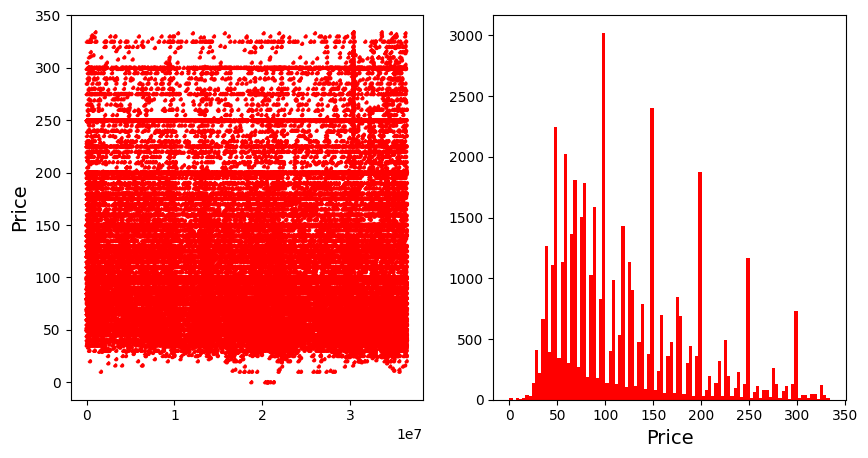

In [136]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(train_df_outliers.index, train_df_outliers['price'], color = 'red', linestyle = '--', s = 5)
ax[1].hist(train_df_outliers['price'], color = 'red', rwidth = 1, bins = 100, )

ax[0].set_ylabel('Price', size = 14)

ax[1].set_xlabel('Price', size = 14)
# ax.set_ylim(0, 1000)
# ax.set_xlim(0, 100)
print("Figuras ilustrando o comportamento da variável preço - agora sem outliers. À esquerda, gráfico de dispersão, à direita, histograma. ")
fig.show()

# Escolha de apartamento para investir para alugar

In [151]:
train_df_outliers.head()

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845.0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.0,2.0,355.0
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632.0,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.0,1.0,365.0
3831,Cozy Entire Floor of Brownstone,4869.0,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270.0,1.0,194.0
5022,Entire Apt: Spacious Studio/Loft by central park,7192.0,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.0,1.0,0.0
5099,Large Cozy 1 BR Apartment In Midtown East,7322.0,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,74.0,1.0,129.0


In [171]:
# Queremos que esteja disponível todos os dias
mask_disponibilidade = train_df_outliers['disponibilidade_365'] >= 365
disponibilidade = train_df_outliers[mask_disponibilidade]

# Queremos que tenha alto número de reviews, arbitrariamente 150
mask_reviews = disponibilidade['numero_de_reviews'] >= 150
numero_reviews = disponibilidade[mask_reviews]

# Por último, queremos que seja "Entire home/apt" e tenha preço mínimo
mask_apt = numero_reviews['room_type'] == 'Entire home/apt'
apt = numero_reviews[mask_apt]

mask_preco = apt['price'] == apt['price'].min()
preco = apt[mask_preco]
preco

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
60611,SpaHa Studio Monthly Rental,292204.0,Manhattan,East Harlem,40.79163,-73.94573,Entire home/apt,125.0,28.0,183.0,2.0,365.0


# Análise de dependências entre price e demais variáveis numéricas

- correlação entre as variáveis numéricas, exceto latitude e longitude. 

In [137]:
train_df_outliers[['price', 'minimo_noites', 'numero_de_reviews', 'disponibilidade_365', 'calculado_host_listings_count', ]].corr()

,price,minimo_noites,numero_de_reviews,disponibilidade_365,calculado_host_listings_count
price,1.000000,0.031462,-0.027685,0.066645,0.174417
minimo_noites,0.031462,1.000000,-0.082938,0.146495,0.133645
numero_de_reviews,-0.027685,-0.082938,1.000000,0.183610,-0.070553
disponibilidade_365,0.066645,0.146495,0.183610,1.000000,0.225671
calculado_host_listings_count,0.174417,0.133645,-0.070553,0.225671,1.000000


Não há alta correlação significativa entre quaiquer variáveis numéricas acima e o preço do quarto!

Contudo, vamos considerar os valores acima de qualquer modo.

# Análise dos valores categóricos

Nenhuma das variáveis, exceto nome (do anúncio), são ambíguas de preços altos ou baixos.

No caso dos nomes, pode-se notar no cabeçalho ou filtrando os valores de 1° e 3° quartil que comumente no valor de "nome" estão presentes as informações de "bairro" e/ou "bairro_group".
Conforme abaixo

In [138]:
train_df_outliers.head()

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845.0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.0,2.0,355.0
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632.0,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.0,1.0,365.0
3831,Cozy Entire Floor of Brownstone,4869.0,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270.0,1.0,194.0
5022,Entire Apt: Spacious Studio/Loft by central park,7192.0,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.0,1.0,0.0
5099,Large Cozy 1 BR Apartment In Midtown East,7322.0,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,74.0,1.0,129.0


In [139]:
train_df_outliers.describe()

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
count,4.590700e+04,45907.000000,45907.000000,45907.000000,45907.000000,45907.000000,45907.000000,45907.000000
mean,6.633739e+07,40.728485,-73.950732,119.966149,6.939639,23.949877,6.641449,109.385606
std,7.756797e+07,0.055329,0.046475,68.147506,19.861076,45.321286,31.013398,130.269348
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,7.720272e+06,40.689230,-73.981920,65.000000,1.000000,1.000000,1.000000,0.000000
50%,3.028359e+07,40.721770,-73.954370,100.000000,2.000000,5.000000,1.000000,39.000000
75%,1.055728e+08,40.763390,-73.934325,159.000000,5.000000,24.500000,2.000000,217.000000
max,2.743213e+08,40.913060,-73.712990,334.000000,1250.000000,629.000000,327.000000,365.000000


Acima do terceiro quartil

In [140]:
over_median = train_df_outliers[train_df_outliers['price'] > 160]
count_nome_cidade = 0
for ids in over_median.index:
    nome = over_median.loc[ids, 'nome']
    if over_median.loc[ids, 'bairro'] in nome:
        count_nome_cidade += 1
    elif over_median.loc[ids, 'bairro_group'] in nome:
        count_nome_cidade += 1
print('Número de relações encontradas entre columa nome, dos valores de preço no terceiro quartil, e columa bairro ou bairro_group:',count_nome_cidade)

Número de relações encontradas entre columa nome, dos valores de preço no terceiro quartil, e columa bairro ou bairro_group: 4157


Abaixo do primeiro quartil

In [141]:
over_median = train_df_outliers[train_df_outliers['price'] < 60]
count_nome_cidade = 0
for ids in over_median.index:
    nome = over_median.loc[ids, 'nome']
    if over_median.loc[ids, 'bairro'] in nome:
        count_nome_cidade += 1
    elif over_median.loc[ids, 'bairro_group'] in nome:
        count_nome_cidade += 1
print('Número de relações encontradas entre columa nome, dos valores de preço no primeiro quartil, e columa bairro ou bairro_group:',count_nome_cidade)

Número de relações encontradas entre columa nome, dos valores de preço no primeiro quartil, e columa bairro ou bairro_group: 2920


 Conclui-se disso, portanto, que para preços acima do terceiro quartil, o número de relações do nome do imóvel e bairro ou bairro_group tende a se sobressair ao mesmo número para preços abaixo do primeiro quartil.

# Nova coluna para valor de relação entre nome e bairro e/ou bairro_group

In [142]:
train_df_outliers.head()

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845.0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.0,2.0,355.0
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632.0,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.0,1.0,365.0
3831,Cozy Entire Floor of Brownstone,4869.0,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270.0,1.0,194.0
5022,Entire Apt: Spacious Studio/Loft by central park,7192.0,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.0,1.0,0.0
5099,Large Cozy 1 BR Apartment In Midtown East,7322.0,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,74.0,1.0,129.0


limpeza do nome com símbolos como .,!"()

In [143]:
def process(df):
    df = df.copy()
    def clear_nome(x):
        wordo = [word.strip("!,.-/()\" '").lower() for word in x.split(' ')]
        wordo = ' '.join(wordo)
        return wordo
    
    df['nome'] = df['nome'].apply(clear_nome)
    df['bairro'] = df['bairro'].apply(clear_nome)
    df['bairro_group'] = df['bairro_group'].apply(clear_nome)
    
    return df

def relacao_nome_bairro(x):
    mask = train_df_processed['nome'] == x
    if train_df_processed.loc[mask, 'bairro'].values[0] in train_df_processed.loc[mask, 'nome'].values[0]:
        return 'yes'
    elif train_df_processed.loc[mask, 'bairro_group'].values[0] in train_df_processed.loc[mask, 'nome'].values[0]:
        return 'yes'
    return 'no'

In [144]:
train_df_processed = process(train_df_outliers)
train_df_processed['rel_nome_bairro'] = train_df_processed['nome'].apply(relacao_nome_bairro)
train_df_processed['rel_nome_bairro']

id
2595        yes
3647        yes
3831         no
5022         no
5099         no
           ... 
36484665     no
36485057    yes
36485431     no
36485609     no
36487245    yes
Name: rel_nome_bairro, Length: 45907, dtype: object

In [145]:
train_df_processed[train_df_processed['rel_nome_bairro'] == 'yes']

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,rel_nome_bairro
id,,,,,,,,,,,,,
2595,skylit midtown castle,2845.0,manhattan,midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.0,2.0,355.0,yes
3647,the village of harlem....new york,4632.0,manhattan,harlem,40.80902,-73.94190,Private room,150.0,3.0,0.0,1.0,365.0,yes
5295,beautiful 1br on upper west side,7702.0,manhattan,upper west side,40.80316,-73.96545,Entire home/apt,135.0,5.0,53.0,1.0,6.0,yes
5441,central manhattan/near broadway,7989.0,manhattan,hell's kitchen,40.76076,-73.98867,Private room,85.0,2.0,188.0,1.0,39.0,yes
6021,wonderful guest bedroom in manhattan for singles,11528.0,manhattan,upper west side,40.79826,-73.96113,Private room,85.0,2.0,113.0,1.0,333.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36482783,brooklyn oasis in the heart of williamsburg,274307600.0,brooklyn,williamsburg,40.71790,-73.96238,Private room,190.0,7.0,0.0,1.0,341.0,yes
36483010,comfy 1 bedroom in midtown east,274311461.0,manhattan,midtown,40.75561,-73.96723,Entire home/apt,200.0,6.0,0.0,1.0,176.0,yes
36483152,garden jewel apartment in williamsburg new york,208514239.0,brooklyn,williamsburg,40.71232,-73.94220,Entire home/apt,170.0,1.0,0.0,3.0,365.0,yes


Alterar features para não considerar a coluna nome, mas a coluna rel_nome_bairro

In [146]:
features.remove('nome')
features.append('rel_nome_bairro')

# Aplicando o modelo

Modelo de regressão, pois estamos lidando com predição de valores contínuos de preço, não classes. 

In [147]:
trees = train_df_processed.copy().reset_index()

trees_train = trees[:int(len(trees)*0.9)]

trees_test = trees[int(len(trees)*0.9):]

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trees_train, label = 'price', task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trees_test, task = tfdf.keras.Task.REGRESSION)


features_without_price = features.copy()
features_without_price.remove('price')
features_without_price

['host_id',
 'bairro_group',
 'bairro',
 'latitude',
 'longitude',
 'room_type',
 'minimo_noites',
 'numero_de_reviews',
 'calculado_host_listings_count',
 'disponibilidade_365',
 'rel_nome_bairro']

In [148]:
model = tfdf.keras.GradientBoostedTreesModel( 
    verbose = 0,
    features = [tfdf.keras.FeatureUsage(name=n) for n in features_without_price],
    exclude_non_specified_features = True,
    random_seed = 12345,
    task = tfdf.keras.Task.REGRESSION,
    num_threads = 4,
)


model.fit(train_ds)

[WARNING 24-02-08 19:50:01.2621 -03 gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-08 19:50:01.2621 -03 gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-08 19:50:01.2622 -03 gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 24-02-08 19:50:08.3464 -03 kernel.cc:1243] Loading model from path /tmp/tmpbhmjf39a/model/ with prefix 25ff22357f144d48
[INFO 24-02-08 19:50:08.3729 -03 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-08 19:50:08.3730 -03 kernel.cc:1075] Use fast generic engine


In [149]:
predict = model.predict(test_ds, verbose=0)[:,0]
predict

array([103.467155,  89.15803 , 116.4399  , ..., 131.13782 , 122.395836,
       104.613846], dtype=float32)

A medida de performance selecionada foi de RMSE, raíz da média de erros quadrados. Utiliza-se essa medida pois se trata de uma análise quantitativa dos erros que o modelo comete em média, havendo flutuações aleatórias que podem subestimar ou superestimar o preço. Dessa forma, essa medida absorve esses erros aleatórios e estabelecem um critério rígido sobre a performance do modelo em um número alto de predições. 

In [150]:
predict_df = pd.DataFrame({"predicted": predict, 'real_data': trees_test['price']})
predict_df['squared_error'] = (predict_df['predicted'] - predict_df['real_data']) ** 2

RMSE = np.sqrt(predict_df['squared_error'].sum()/len(predict_df))
print('O valor de Raiz do erro médio ao quadrado é', np.round(RMSE, 2), '$, o que está abaixo do valor de desvio padrão de 76.32 $')

O valor de Raiz do erro médio ao quadrado é 52.58 $, o que está abaixo do valor de desvio padrão de 76.32 $


In [32]:
trees_test.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
count,4.591000e+03,4.591000e+03,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000
mean,3.519251e+07,1.491779e+08,40.729668,-73.946537,129.119582,6.993030,1.811152,12.051405,156.298846
std,7.615929e+05,1.046325e+08,0.057065,0.053666,76.319306,16.050789,3.054525,52.586793,130.691346
min,3.385217e+07,1.557400e+04,40.506410,-74.244420,10.000000,1.000000,0.000000,1.000000,0.000000
25%,3.449842e+07,3.578391e+07,40.692415,-73.984160,68.000000,1.000000,0.000000,1.000000,34.000000
50%,3.521759e+07,1.610571e+08,40.726460,-73.952830,100.000000,2.000000,0.000000,1.000000,122.000000
75%,3.584279e+07,2.590833e+08,40.762695,-73.926080,180.000000,5.000000,2.000000,3.000000,300.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.716900,333.000000,500.000000,32.000000,327.000000,365.000000


# Mudando os parâmetros para os recomendados do modelo

In [33]:
model = tfdf.keras.GradientBoostedTreesModel( 
    verbose = 0,
    features = [tfdf.keras.FeatureUsage(name=n) for n in features_without_price],
    exclude_non_specified_features = True,
    random_seed = 12345,
    num_trees = 2000,
    min_examples = 1,
    growing_strategy="BEST_FIRST_GLOBAL",
    categorical_algorithm="RANDOM",
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_normalization="MIN_MAX",
    sparse_oblique_num_projections_exponent=1.0,
    shrinkage = 0.02,
    task = tfdf.keras.Task.REGRESSION,
    num_threads = 4,
)

model.fit(train_ds)

[WARNING 24-02-08 17:19:30.9030 -03 gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-08 17:19:30.9030 -03 gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-08 17:19:30.9030 -03 gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-08 17:23:42.7967 -03 kernel.cc:1243] Loading model from path /tmp/tmp_s4s5eb5/model/ with prefix 1597e1662f864e82
[INFO 24-02-08 17:23:43.1161 -03 decision_forest.cc:660] Model loaded with 709 root(s), 43075 node(s), and 11 input feature(s).
[INFO 24-02-08 17:23:43.1161 -03 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 24-02-08 17:23:43.1162 -03 kernel.cc:1075] Use fast generic engine


In [34]:
predict = model.predict(test_ds, verbose=0)[:,0]
predict

array([105.61824 ,  85.6219  , 118.17321 , ..., 127.2515  , 117.60797 ,
       110.148895], dtype=float32)

In [35]:
predict_df = pd.DataFrame({"predicted": predict, 'real_data': trees_test['price']})
predict_df['squared_error'] = (predict_df['predicted'] - predict_df['real_data']) ** 2

RMSE = np.sqrt(predict_df['squared_error'].sum()/len(predict_df))
print('O valor de Raiz do erro médio ao quadrado é', np.round(RMSE, 2), '$, o que é pouco menos do valor do obtido com modelo default')

O valor de Raiz do erro médio ao quadrado é 52.03 $, o que é pouco menos do valor do obtido com modelo default


# Comparação com modelo de regressão linear do sklearn

In [211]:
train_lin = train_df_processed.copy()
train_lin.head()

,nome,host_id,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,rel_nome_bairro
id,,,,,,,,,,,,,
2595,skylit midtown castle,2845.0,manhattan,midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.0,2.0,355.0,yes
3647,the village of harlem....new york,4632.0,manhattan,harlem,40.80902,-73.94190,Private room,150.0,3.0,0.0,1.0,365.0,yes
3831,cozy entire floor of brownstone,4869.0,brooklyn,clinton hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270.0,1.0,194.0,no
5022,entire apt: spacious studio/loft by central park,7192.0,manhattan,east harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.0,1.0,0.0,no
5099,large cozy 1 br apartment in midtown east,7322.0,manhattan,murray hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,74.0,1.0,129.0,no


In [212]:
X_train = train_lin[features_without_price]
Y_train = train_lin['price']
X_train.head()

,host_id,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365,rel_nome_bairro
id,,,,,,,,,,,
2595,2845.0,manhattan,midtown,40.75362,-73.98377,Entire home/apt,1.0,45.0,2.0,355.0,yes
3647,4632.0,manhattan,harlem,40.80902,-73.94190,Private room,3.0,0.0,1.0,365.0,yes
3831,4869.0,brooklyn,clinton hill,40.68514,-73.95976,Entire home/apt,1.0,270.0,1.0,194.0,no
5022,7192.0,manhattan,east harlem,40.79851,-73.94399,Entire home/apt,10.0,9.0,1.0,0.0,no
5099,7322.0,manhattan,murray hill,40.74767,-73.97500,Entire home/apt,3.0,74.0,1.0,129.0,no


Como há valores categóricos, há-se de tranformá-los em valores que possam ser conjugados pelo modelo de regressão linear:

In [213]:
def dummies(X):
    X = X.copy()
        
    objectos = X.select_dtypes(include='object', exclude=None)

    not_objectos = X.select_dtypes(include=None, exclude=object).reset_index()
    try:
        objectos = pd.get_dummies(data = objectos, drop_first = True).reset_index()
        
    except:
        pass
    X = pd.merge(objectos,not_objectos, on = 'id')
    X = X.set_index('id')
    return X

In [214]:
X_train = dummies(X_train)
X_train.head()


,bairro_group_brooklyn,bairro_group_manhattan,bairro_group_queens,bairro_group_staten island,bairro_arden heights,bairro_arrochar,bairro_arverne,bairro_astoria,bairro_bath beach,bairro_battery park city,...,room_type_Private room,room_type_Shared room,rel_nome_bairro_yes,host_id,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,,,,,,,,,,
2595,False,True,False,False,False,False,False,False,False,False,...,False,False,True,2845.0,40.75362,-73.98377,1.0,45.0,2.0,355.0
3647,False,True,False,False,False,False,False,False,False,False,...,True,False,True,4632.0,40.80902,-73.94190,3.0,0.0,1.0,365.0
3831,True,False,False,False,False,False,False,False,False,False,...,False,False,False,4869.0,40.68514,-73.95976,1.0,270.0,1.0,194.0
5022,False,True,False,False,False,False,False,False,False,False,...,False,False,False,7192.0,40.79851,-73.94399,10.0,9.0,1.0,0.0
5099,False,True,False,False,False,False,False,False,False,False,...,False,False,False,7322.0,40.74767,-73.97500,3.0,74.0,1.0,129.0


In [215]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = .10, random_state = 40)

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

In [216]:
Y_predict = regr.predict(X_test)

# Y_predict = pls.predict(X_test)

# X_test.reset_index(inplace = True)

predict_df = pd.DataFrame({"predicted": Y_predict, 'real_data': Y_test})
predict_df['squared_error'] = (predict_df['predicted'] - predict_df['real_data']) ** 2

RMSE = np.sqrt(predict_df['squared_error'].sum()/len(predict_df))
print('O valor de Raiz do erro médio ao quadrado para regressão linear sklearn é', np.round(RMSE, 2), '$, o que é ainda menor que para os modelos anteriores.')

O valor de Raiz do erro médio ao quadrado para regressão linear sklearn é 48.16 $, o que é ainda menor que para os modelos anteriores.


# Conclusão e salvar modelo

Apesar de os modelos apresentarem performances de acurácia similares, opta-se por utilizar o modelo de regressão linear sklearn, pois é mais simples e rápido que os realizados por tensorflow. 

Teste para {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}


In [300]:
teste = pd.DataFrame([{'id': 2595, 'nome': 
        'Skylit Midtown Castle', 
        'host_id': 2845, 
        'host_name': 'Jennifer',
        'bairro_group': 'Manhattan',
        'bairro': 'Midtown',
        'latitude': 40.75362,
        'longitude': -73.98377,
        'room_type': 'Entire home/apt',
        'price': 225,
        'minimo_noites': 1,
        'numero_de_reviews': 45,
        'ultima_review': '2019-05-21',
        'reviews_por_mes': 0.38,
        'calculado_host_listings_count': 2,
        'disponibilidade_365': 355}])

teste = teste.set_index('id')
teste

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,,,,,,,,,,,,,,,
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [301]:
def relacao_nome_bairro(x):
    mask = teste['nome'] == x
    if teste.loc[mask, 'bairro'].values[0] in teste.loc[mask, 'nome'].values[0]:
        return 'yes'
    elif teste.loc[mask, 'bairro_group'].values[0] in teste.loc[mask, 'nome'].values[0]:
        return 'yes'
    return 'no'

In [302]:
teste = process(teste)
teste['rel_nome_bairro'] = teste['nome'].apply(relacao_nome_bairro)
teste = teste[features_without_price]
teste = dummies(teste)
teste

,host_id,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
id,,,,,,,
2595,2845,40.75362,-73.98377,1,45,2,355


In [307]:
features_regr = X_train.columns
features_regr = pd.DataFrame(features_regr)
features_regr.to_csv('features.csv')
features_regr

,0
0,bairro_group_brooklyn
1,bairro_group_manhattan
2,bairro_group_queens
3,bairro_group_staten island
4,bairro_arden heights
...,...
227,longitude
228,minimo_noites
229,numero_de_reviews
230,calculado_host_listings_count


In [326]:
features_regr = pd.read_csv('features.csv')
features_regr = list(features_regr['0'].values)


In [317]:
features_regr_df = pd.DataFrame(columns=features_regr)

features_regr_df

,bairro_group_brooklyn,bairro_group_manhattan,bairro_group_queens,bairro_group_staten island,bairro_arden heights,bairro_arrochar,bairro_arverne,bairro_astoria,bairro_bath beach,bairro_battery park city,...,room_type_Private room,room_type_Shared room,rel_nome_bairro_yes,host_id,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365


In [323]:
for column in features_regr_df:
#     print(column)
    if column in teste.columns:
        features_regr_df[column] = teste[column].values[0]
#         print('YESS')
    else:
        features_regr_df[column] = False

In [324]:
features_regr_df 

,bairro_group_brooklyn,bairro_group_manhattan,bairro_group_queens,bairro_group_staten island,bairro_arden heights,bairro_arrochar,bairro_arverne,bairro_astoria,bairro_bath beach,bairro_battery park city,...,room_type_Private room,room_type_Shared room,rel_nome_bairro_yes,host_id,latitude,longitude,minimo_noites,numero_de_reviews,calculado_host_listings_count,disponibilidade_365
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,2845,40.75362,-73.98377,1,45,2,355


In [294]:
print('O valor previsto para o apartamento sugerido como teste é $',round(regr.predict(features_regr_df)[0], 0))
print('O que difere do valor verdadeiro, 225$, por 24$')

O valor previsto para o apartamento sugerido como teste é $ 201.0
O que difere do valor verdadeiro, 225$, por 24$


# Salvar o modelo utilizando pickle:

In [278]:
import pickle
pickle.dump(regr, open('linear_regression_model.pkl', 'wb'))